Answer to theoretical questions:

<span style="color:red">Magnetization operator: $m(\phi)=\frac{\sinh(\beta h\pm\phi)}{\cosh(\beta \pm\phi)}=\tanh(\beta h+\phi)$<span>
    
<span style="color:red">Energy per site operator: $\epsilon(\phi)=-\frac{\phi^2-J\beta}{J\beta^2}\frac1{2N}-h\tanh(\beta h+\phi)$<span>
    
<span style="color:red">$\dot{\phi}=p$<span>
    
<span style="color:red">$\dot{p}=-\frac{\phi}{\beta J}+N\cdot \tanh{(\beta\cdot h+\phi)}$<span>

In [33]:
def leapfrog_plot():
    global N_md
    p_0=0.5
    phi_0=.5
    H_0=H(p_0,phi_0)
    for i in range(100):
        N_md=i+2
        p,phi=leapfrog(p_0,phi_0)
        plt.plot(i+2,abs((H(p,phi)-H_0)/H_0), 'x', color='b')
    plt.semilogy()    
    plt.show() 

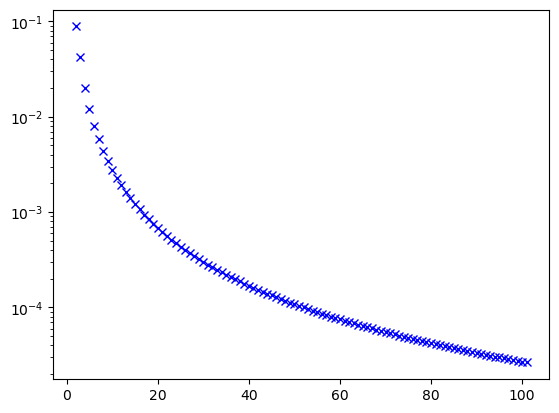

In [34]:
leapfrog_plot()

The graph looks like we expected it. It shows that for large $N_{md}$ the energy of the old and new configuration is almost the same. This will later be important to achieve a high acceptance probability.  

In [35]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
from  math import *
import matplotlib.pyplot as plt
import scipy.optimize as so
import scipy.special as sp
import mpmath as mp


N_md = 50 #Leapfrog integration steps
N_en = 10
N_cfg = 15000
beta=1
N=20
h=0.5
beta_h=0.5
J=1/N
phi_0 = 0
p_0 = 0 
I = 10
A = 1 
ar=0

This is just defining of variables. 

In [36]:
def calc_magn(phi_en): 
    global beta_h
    global N_cfg
    global N_en
    global I
    global A
    
    M_array = np.zeros(N_cfg)
    
    for i in range(N_cfg):
        M_array[i] = np.tanh(beta_h+phi_en[i]) 
      
    M_array = M_array[I:]
    M=np.sum(M_array)
    
    return M/(N_cfg)

input: Array with values of $\phi$ for an entire ensemble; output: Mean Magnetization of the ensemble  
In the beginning of the array we cut away some configurations for thermalization. 

In [37]:
def calc_eps(phi_en): 
    global beta_h
    global h
    global beta
    global N_cfg
    global J
    global I
    
    e_array = np.zeros(N_cfg)
        
    for i in range(N_cfg):
        e_array[i]= (phi_en[i]**2-J*beta)/(J*beta**2)/(2*N)+h*mp.tanh(beta_h+phi_en[i])
    e_array=e_array[I:]
    e = np.sum(e_array)
    
    return -e/N_cfg

input: Array with values of $\phi$ for an entire ensemble; output: Mean energy per site of the ensemble  
In the beginning of the array we cut away some configurations for thermalization. 

In [38]:
def f(n):
    global J
    global beta_J
    global beta_h
    global beta 
      
   
    return(np.exp((beta*J*n**2)/2+beta_h*n))

input: x; output: f(x)

In [39]:
def partition_func_theo():
    global beta_h
    global N
    global beta_J
    
    Z = 0
   
    
    for n in range(N+1):
        Z += sp.binom(N, n)*f(N-2*n)
    
    return(Z)

input: ; output: Z(N,beta,J,h)

In [40]:
def beta_eps_theo():
    global N
    global beta_J
    global beta_h
    
    value = 0
    
    
    for n in range(N+1):
        
        value += sp.binom(N, n)*(1/2*beta*J*(N-2*n)**2+beta_h*(N-2*n))*f(N-2*n)
    
    value = -value/(N*partition_func_theo())
    
    return(value)

input: ; output: beta*eps(N,beta,J,h)

In [41]:
def m_theo():
    global N
    global beta_J
    global beta_h
    global J
    
    value = 0
    
    for n in range(N+1):
        value += sp.binom(N, n)*(N-2*n)*f(N-2*n)
        
    value = value/(N*partition_func_theo())
    return(value)

input: ; output: m(N,beta,J,h)

In [42]:
def leapfrog(p_0,phi_0):
    global beta 
    global J
    global N 
    global h
    global N_md
    
    eps=1/N_md
    phi=phi_0+eps/2*p_0
    p_leap=p_0
    for i in range(N_md-1):
        p_leap=p_leap-eps*(phi/(beta*J)-N*mp.tanh(beta*h+phi))
        phi=phi+eps*p_leap
    p_leap=p_leap-eps*(phi/(beta*J)-N*mp.tanh(beta*h+phi))
    phi=phi+eps/2*p_leap
    
    return p_leap,phi

input: p_0, phi_0; output: p_f,phi_f  
code as explained on the sheet

In [43]:
def H(p,phi):
    global beta 
    global J 
    global h 
    
    return p**2/2+phi**2/(2*beta*J)-N*mp.log(2*mp.cosh(beta*h+phi))

input p,phi: ; output: H(p,phi)

In [44]:
def HMC(): #Does one iteration of the Markov-Chain and return phi
    global N_md
    global p_0
    global phi_0
    global p
    global ar
    
    p = np.random.normal(loc=0.0, scale=1.0) 
    
    p_l,phi_l = leapfrog(p,phi_0)    
    
    
    P_acc = np.exp(float(H(p,phi_0)-H(p_l,phi_l)))
    
        
    if P_acc > np.random.rand(): 
        
        phi_0 = phi_l
        ar=ar+1

    return phi_0

Classical HMC-Algo, which returns the next element of the markov chain. Candidates are created with the leapfrog-algo. In our case it also keeps track of the acceptance probability with ar.

In [45]:
def ensemble(): #Generates an ensemble of phi and counts the acceptance rate
    global N_en
    global N_md
    global p_0
    global phi_0
    
    phi_en_calc =np.zeros(N_cfg)
   
    
    for i in range(N_cfg):
        phi_en_calc[i] = HMC()

    
    return phi_en_calc

This generates the ensemble which is represented by the $\phi$ which is stored i an array. The array if filled by looping over the HMC-algo.

In [46]:
def m_J_5():  
    global h
    global N_cfg
    global beta_J
    global I
    global A
    global ar
    global N 
    global phi_en
    global J 
    global ar
    global phi_en_temp
    global N_md
    
    E=18 #amount of points for the graph
    D=4
    phi_en=np.zeros(N_cfg)
    phi_en_temp=np.zeros((E*D,N_cfg))
    colours=['b','g','r','c','m','y','k']    
   
    for m in range(D): #different lattice sizes      
        N=(m+1)*5
        final_M=np.zeros(E)
        ar=0
        theo_values = []
        N_md=(m+1)*7
        for j in range(E): #Calculation for different J
            J=(0.2+(j/10))/N     # J=beta*J \in [0.2, 2.2) #J sollte in einheiten 1/N sein
            phi_en = ensemble()
            phi_en_temp[j+(m*E)]=phi_en
            final_M[j] = calc_magn(phi_en)
        J_x=np.arange(0.2,2.0,0.1)/N
        for J in J_x:
            theo_values.append(m_theo())
          
          
        print("Acceptance rate for lattice size ", N," :", ar/(N_cfg*E)*100,"%")
        plt.plot(J_x**(-1),final_M,color=colours[m+1],\
                 label='$N=$%s'%str(N))
        plt.plot(J_x**(-1),theo_values, color=colours[m+1], linestyle='dashed', label='Theory for $N=$%s'%str(N))
    plt.legend()
    plt.xlabel(r"$(J/N)^{-1}$")
    plt.ylabel(r"$m((J/N)^{-1})$")
    plt.show()

We run through different N and J with for loops. We save all our created ensembles globally in phi_en_temp, so that we dont have to create them again. We vary our $N_{md}$ for the different lattice sizes. We plot the magnetization as well as the theoretically expected magnetization against $(J/N)^{-1}$.

Acceptance rate for lattice size  5  : 99.25555555555555 %
Acceptance rate for lattice size  10  : 99.76666666666667 %
Acceptance rate for lattice size  15  : 98.9074074074074 %
Acceptance rate for lattice size  20  : 99.09259259259258 %


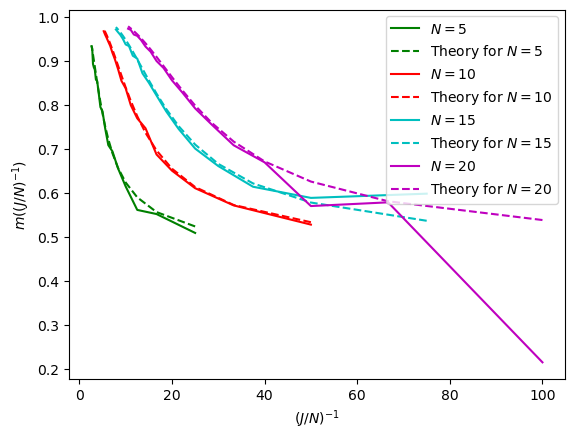

In [47]:
m_J_5()

One can see that the acceptance probability is very high, which is good but also costly.  
The graphs fit the theoretical expectation pretty well. One could only argue that for large lattice sizes and large $(J/N)^{-1}$ the calculated value differs a bit from theoretical expectation. This is due to the fact that our size of the ensemble is fixed and therefor its very costly to higher the value which would increase the ensemble size for all configurations.  

In [48]:
def e_J_5():  
    global h
    global N_cfg
    global beta_J
    global I
    global A
    global ar
    global N 
    global phi_en
    global J 
    global ar
    global phi_en_temp
 
    
    E=18 #amount of points for the graph
    D=4
    
    
    colours=['b','g','r','c','m','y','k']    
   
    for m in range(D): #different lattice sizes      
        N=(m+1)*5
        final_e=np.zeros(E)
        ar=0
        theo_values = []
        for j in range(E): #Calculation for different J
            J=(0.2+(j/10))/N    
            phi_en=phi_en_temp[j+(m*E)]
            final_e[j] = calc_eps(phi_en)
        J_x=np.arange(0.2,2.0,0.1)/N
        for J in J_x:
            theo_values.append(beta_eps_theo())
        plt.plot(J_x**(-1),final_e,color=colours[m+1],\
                 label='$N=$%s'%str(N))
        plt.plot(J_x**(-1),theo_values, color=colours[m+1], linestyle='dashed', label='Theory for $N=$%s'%str(N))
    plt.legend()
    plt.xlabel(r"$(J/N)^{-1}$")
    plt.ylabel(r"$\beta\cdot \epsilon(J/N)^{-1}$")
    plt.show()

We run through different N and J with for loops. We use the saved ensembles in phi_en_temp. We plot the energy per site as well as the theoretically expected energy per site against $(J/N)^{-1}$.

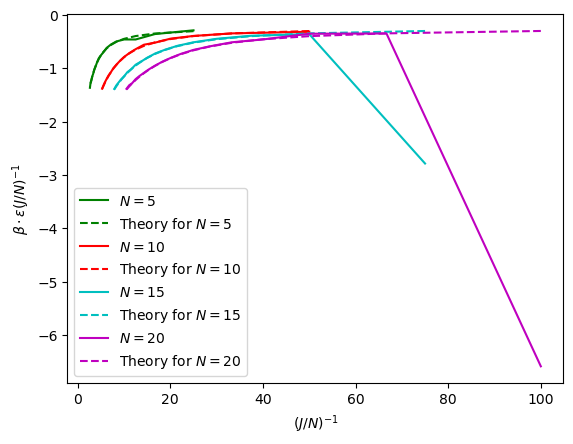

In [49]:
e_J_5()

The energy per site also matches the expected values very well. As well as above, there are small deviations for large lattice sizes and large $(J/N)^{-1}$. This is to be expected, because our calculations are based on the same ensembles. 